In [1]:
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
import numpy as np
import pandas as pd
from glob import glob
from scipy.stats import multivariate_normal,kstest,norm,t
from scipy.interpolate import interp1d
from plottinglib import *
from scipy.special import erf
from datalib import dataloader, dataconversion, wharton
from joblib import Parallel, delayed
from scipy.optimize import minimize
#from pynverse import inversefunc
from statsmodels.distributions.empirical_distribution import ECDF
plt.style.use('stylesheet')
from datalib import *
import statsmodels.api as sm
from frontiers import EffFrontier, optimize
from plottinglib import *
from pandas.tseries.offsets import Day, BDay
from datetime import date
from scipy.interpolate import RegularGridInterpolator
from MCMC_sampling import *
import matplotlib.ticker as mtick
from HMM_fitter import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pypfopt_risk_models import *
from OPAL_GMM import *
import scipy.stats as st
from backtesting import *
import os
import h5py
from joblib import wrap_non_picklable_objects
from hmmlearn import hmm
from arch import arch_model
Ncores=6
plt.style.use('stylesheet')

ModuleNotFoundError: No module named 'plottinglib'

In [2]:
OPAL_naming = pd.read_excel('OPAL_nameing_conversion.xlsx')

In [3]:
class dataloader():
    def __init__(self):
        return
    def wildshire(self):
        wildshire = pd.read_excel('./wildshire5000.xls',header=None)
        wildshire.columns = ['Date','Wildshire5000']
        wildshire = wildshire.set_index('Date').astype(float)
        wildshire.index = pd.to_datetime(wildshire.index)
        return wildshire
    def UST(self):
        UST5 = pd.read_excel('./treasury_5y.xls',header=None)
        UST5.columns = ['Date','Treasury5y']
        UST5 = UST5.set_index('Date').astype(float)
        UST5.index = pd.to_datetime(UST5.index)

        UST10 = pd.read_excel('./treasury_10yr.xls')
        UST10.columns = ['Date','Treasury10y']
        UST10 = UST10.set_index('Date').astype(float)
        UST10.index = pd.to_datetime(UST10.index)

        UST10_2 = pd.read_excel('./10year_minus_2year.xls')
        UST10_2.columns = ['Date','Treasury10-2y']
        UST10_2 = UST10_2.set_index('Date').astype(float)
        UST10_2.index = pd.to_datetime(UST10_2.index)
        UST = UST5.join(UST10).join(UST10_2).dropna()

        UST10_3m = pd.read_excel('./10year_minus_3month.xls')
        UST10_3m.columns = ['Date','Treasury10-3m']
        UST10_3m = UST10_3m.set_index('Date').astype(float)
        UST10_3m.index = pd.to_datetime(UST10_3m.index)
        UST = UST5.join(UST10).join(UST10_2).join(UST10_3m).dropna()
        return UST
    def NASDAQ(self):
        nasdaq = pd.read_excel('./nasdaq_since_1970.xls',header=None)
        nasdaq.columns = ['Date','Nasdaq']
        nasdaq = nasdaq.set_index('Date').astype(float)
        nasdaq.index = pd.to_datetime(nasdaq.index)
        return nasdaq
    def inflation(self):
        breakeven_inflation = pd.read_csv('./breakeven_inflation_5y.csv')
        breakeven_inflation.DATE = pd.to_datetime(breakeven_inflation.DATE)
        breakeven_inflation = breakeven_inflation.set_index('DATE')
        breakeven_inflation.columns = ['Breakeven_Inflation_5y']
        breakeven_inflation = breakeven_inflation.replace('.',np.nan).astype(float)
        return breakeven_inflation
    def OPAL(self):
        OPAL_ts = pd.read_pickle('OPAL_ts2.pickle')
        OPAL_ts = OPAL_ts[OPAL_ts.isna().sum().sort_values().index[OPAL_ts.isna().sum().sort_values() <2500]].dropna()
        #OPAL_ts = OPAL_ts.drop('EUR001M Index',axis=1)
        return OPAL_ts
    def HML(self):
        fmb_df = pd.read_csv('../Arnott plus value/F-F_Research_Data_Factors_daily.CSV')
        fmb_df.columns = ['Date', 'Market','SMB','HML','RF']
        fmb_df.Date = pd.to_datetime(fmb_df.Date,format='%Y%m%d')
        fmb_df = fmb_df.set_index('Date')
        fmb_df = fmb_df.astype(float)
        fmb_df = fmb_df.loc['1945':]
        return fmb_df
    def join(self):
        wildshire = self.wildshire()
        nasdaq = self.NASDAQ()
        fmb_df = self.HML()
        OPAL_ts = self.OPAL()
        breakeven_inflation = self.inflation()
        UST = self.UST()
        df = wildshire.join(nasdaq).join(fmb_df.HML).join(OPAL_ts,how='inner').join(breakeven_inflation).join(UST)
        return df, UST, fmb_df, breakeven_inflation
    def convert_return(self):
        df, UST, fmb_df, breakeven_inflation = self.join()
        df = df.loc['2003':].fillna(method='ffill').dropna()
        df = df.loc[:'2021-01']

        # Convert to returns
        df = np.log(df) - np.log(df.shift(1))
        df['Treasury5y'] = UST.loc['2003':,'Treasury5y'].fillna(method='ffill').diff()
        df['Treasury10y'] = UST.loc['2003':,'Treasury10y'].fillna(method='ffill').diff()
        df['Treasury10-2y'] = UST.loc['2003':,'Treasury10-2y'].fillna(method='ffill').diff()
        df['Treasury10-3m'] = UST.loc['2003':,'Treasury10-3m'].fillna(method='ffill').diff()
        df['Breakeven_Inflation_5y'] = breakeven_inflation.loc['2003':].fillna(method='ffill').diff()
        df['HML'] = np.log(fmb_df['HML'].loc['2003':]*0.01+1)
        df.Breakeven_Inflation_5y.loc['2008-12-01']=np.mean(df.Breakeven_Inflation_5y)
        df = df.dropna()
        df.columns = [w.split(' Index')[0] for w in df.columns]

        df_daily = df.copy()
        df_weekly = df.resample('1w').sum().dropna()
        
        df_weekly['TreasuryBin'] = pd.qcut(df_weekly.Treasury10y,q=[0,0.05,0.95,1],labels=['ExtremeLow','Normal','ExtremeHigh'])
        df_weekly_noextremes = df_weekly[df_weekly.TreasuryBin=='Normal']

        df_daily['TreasuryBin'] = pd.qcut(df.Treasury10y,q=[0,0.05,0.95,1],labels=['ExtremeLow','Normal','ExtremeHigh'])
        df_daily_noextremes = df_daily[df_daily.TreasuryBin=='Normal']
        return df_daily,df_daily_noextremes, df_weekly, df_weekly_noextremes
    
df_daily,df_daily_noextremes, df_weekly, df_weekly_noextremes = dataloader().convert_return()

In [1143]:
# Numerically obtain inverse CDF of GMM
def inverse_GMM_CDF(weights, means,variances,scalefac):
    def diff(x,function,a):
        y = function(x)
        return (y-a)**2
    # Define normal CDF of GMM
    cdf_GMM = lambda x: np.sum([weights[j]*gauss_cdf(x, means[j], np.sqrt(variances[j])) for j in range(len(weights))],axis=0)
    # Now define a grid over which to equate the inverse
    # For that we need to get the min and max; we know thats 0 and 1
    xvalues = np.hstack((np.logspace(-8,-2,100),1-np.logspace(-8,-2,100),np.linspace(0.0001,1-0.0001,800)))
    # For each of these x values, determine the inverse using minimization
    
    inverses = np.zeros(len(xvalues))
    for i in range(len(inverses)):
        res = minimize(diff, x0=0, args=(cdf_GMM,xvalues[i]), method='Nelder-Mead', tol=1e-15)
        inverses[i] = res.x
    # Do interpolation of this
    f = interp1d(xvalues,inverses/scalefac,fill_value='extrapolate')
    return f, xvalues, inverses/scalefac

def inverse_GMM_arbitraryCDF(CDF):
    def diff(x,function,a):
        y = function(x)
        return 10000*(y-a)**2
    # Define normal CDF of GMM
    # Now define a grid over which to equate the inverse
    # For that we need to get the min and max; we know thats 0 and 1
    xvalues = np.hstack((np.logspace(-10,-2.150),1-np.logspace(-10,-2.150),np.linspace(0.0001,1-0.0001,1000)))
    xvalues = np.sort(xvalues)
    # For each of these x values, determine the inverse using minimization
    
    inverses = np.zeros(len(xvalues))
    for i in range(len(inverses)):
        res = minimize(diff, x0=0, args=(CDF,xvalues[i]), method='Nelder-Mead', tol=1e-15)
        inverses[i] = res.x
    # Do interpolation of this
    f = interp1d(xvalues,inverses,fill_value='extrapolate')
    return f, xvalues, inverses

In [5]:
stocks = ['BCIF1T', 'BEITGA', 'BRDHTREU', 'Breakeven_Inflation_5y', 'CMBL',
       'CRYTR', 'G250GLEU', 'H0CE', 'HFRXGLE', 'HML', 'Immobilier', 'JBCDHECP',
       'JGENVHEG', 'JGENVUEG', 'JPGCHECP', 'LECFTREU', 'LECPTREU', 'LESDTREU',
       'LETSTREU', 'LEU1TREU', 'LF96TREH', 'LG50TREH', 'LTFRTREU', 'MSDEE15N',
       'MSDEEEMN', 'MSDEUSN', 'Nasdaq', 'PD', 'PE', 'SBWMEU1L', 'SBWMUD1U',
       'SPBDRLEH', 'Structured']
stocks = ['MSDEUSN','Nasdaq']

In [6]:
# Estimate covariance matrix
covmat = df_daily[stocks].corr().values
means  = df_daily[stocks].mean().values
from scipy import stats
s = stats.multivariate_normal(cov=covmat).rvs(100000)
#s=s.reshape(-1,1)

In [324]:
# Fit GMM to each stock
fitted_GMM = {}
icdf_GMMs = {}
icdf_emps = {}
for stock in stocks:
    gm = GaussianMixture(n_components=3,n_init=50,tol=1e-6)    
    gm.fit(df_daily[stock].values.reshape(-1,1))    
    fitted_GMM[stock] = gm
    weights = gm.weights_
    means = gm.means_
    variances = gm.covariances_
    # Get inverse CDF
    icdf_GMM,_,_ = inverse_GMM_CDF(weights, means, variances)    
    icdf_emp,_,_ = inverse_GMM_arbitraryCDF(ECDF(df_daily[stock].values.flatten()))    
    icdf_GMMs[stock] = icdf_GMM
    icdf_emps[stock] = icdf_emp

In [325]:
# Convert to uniform
simulated_GMM = {}
simulated_emp = {}
uniform = {}
for i,stock in enumerate(stocks):
    # Get weights from GMM fitted to establish empirical CDF
    gm = fitted_GMM[stock]
    weights = gm.weights_
    means = gm.means_
    variances = gm.covariances_
    # Get inverse CDF
    icdf_GMM = icdf_GMMs[stock]
    icdf_emp = icdf_emps[stock]
    # Transform simulations to uniform distribution
    mu_sim = means[i]
    sigma_sim = np.sqrt(covmat[i,i])
    # Save uniform random variables
    uniform[stock] = gauss_cdf(s[:,i], mu_sim,sigma_sim)
    # Convert using icdf of GMM to GMM distribution
    simulated_GMM[stock] = icdf_GMM(uniform[stock])
    simulated_emp[stock] = icdf_emp(uniform[stock])

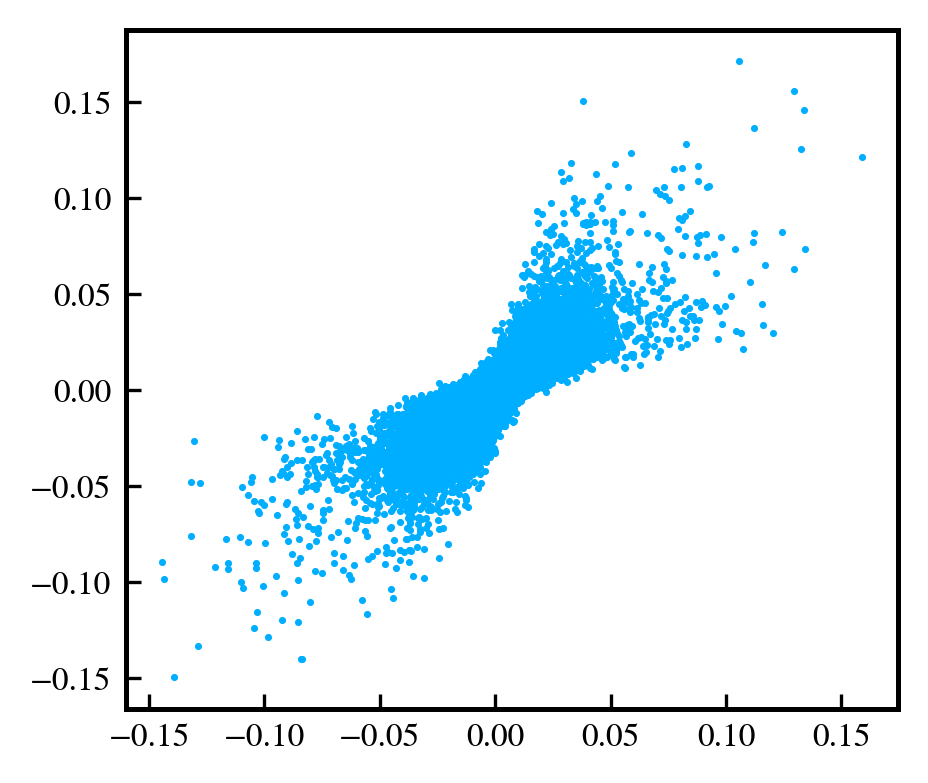

In [74]:
plt.scatter(simulated_GMM['MSDEUSN'],simulated_GMM['Nasdaq'],s=0.5)
plt.show()

In [129]:
stats.ks_2samp(df_daily['MSDEUSN'].values.flatten(), simulated_emp['MSDEUSN'][:len(df_daily)])

Ks_2sampResult(statistic=0.019634860489149142, pvalue=0.6263712982752732)

In [130]:
stats.ks_2samp(df_daily['MSDEUSN'].values.flatten(), simulated_GMM['MSDEUSN'][:len(df_daily)])

Ks_2sampResult(statistic=0.028246641405442696, pvalue=0.19418155709401272)

NameError: name 'simulated_GMM' is not defined

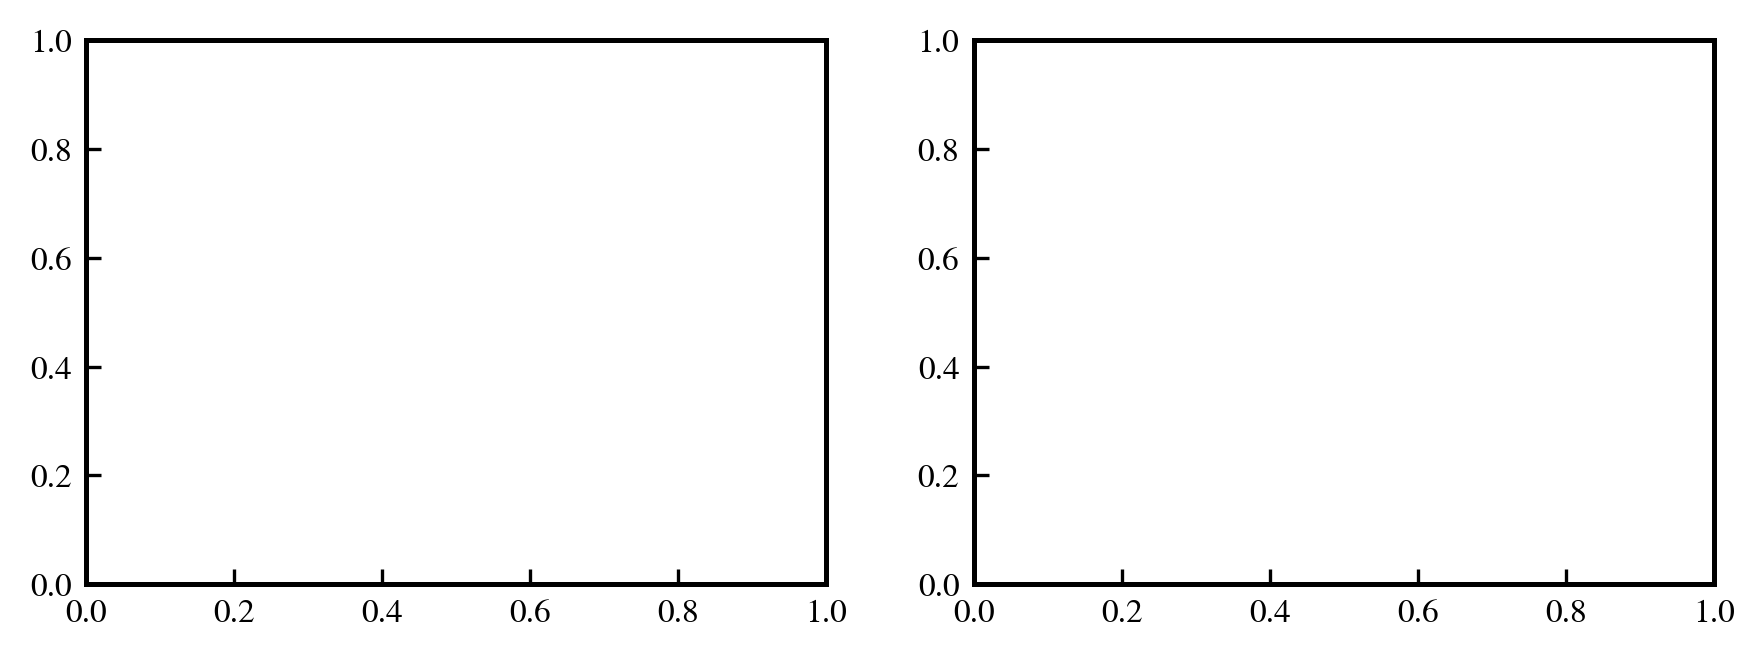

In [12]:
fig,axes = plt.subplots(ncols=2,figsize=(7,2.4))
axes[0].hist(100*simulated_GMM['MSDEUSN'],lw=1,histtype='step',normed=True,bins=100*np.arange(-0.05,0.05,0.001), label='Gaussian Mixture Copula')
axes[0].hist(100*simulated_emp['MSDEUSN'],lw=1,histtype='step',normed=True,bins=100*np.arange(-0.05,0.05,0.001),label='Empirical copula')
axes[0].hist(100*df_daily['MSDEUSN'],lw=1,histtype='step',normed=True,bins=100*np.arange(-0.05,0.05,0.001), label='Empirical Distribution')
axes[0].legend(frameon=1,loc='lower right')
axes[0].set_xlim(-4,4)
axes[0].set_ylabel('Density')
axes[0].set_xlabel('Daily return (%)')
axes[0].xaxis.set_major_formatter(mtick.PercentFormatter())

axes[1].plot(100*ECDF(simulated_GMM['MSDEUSN']).x,ECDF(simulated_GMM['MSDEUSN']).y, label='Gaussian Mixture Copula',lw=1)
axes[1].plot(100*ECDF(simulated_emp['MSDEUSN']).x,ECDF(simulated_emp['MSDEUSN']).y, label='Empirical copula',lw=1)
axes[1].plot(100*ECDF(df_daily['MSDEUSN']).x,ECDF(df_daily['MSDEUSN']).y, label='Empirical Distribution',lw=1)
axes[1].legend(frameon=1,loc='lower right')
axes[1].set_xlim(-4,4)
axes[1].set_xlabel('Daily return (%)')
axes[1].set_ylabel('Density')

import matplotlib.ticker as mtick


axes[1].xaxis.set_major_formatter(mtick.PercentFormatter())


plt.tight_layout()
plt.savefig('Copula_transformation_MSDEUSN.pdf')
plt.show()

<h3>Alternative using Empirical Copula and GMM distributions</h3>

In [565]:
# Nasdaq and EU equity
nasdaq_uniform   = ECDF(df_daily['Nasdaq'])(df_daily['Nasdaq'])
stockseu_uniform = ECDF(df_daily['MSDEUSN'])(df_daily['MSDEUSN'])

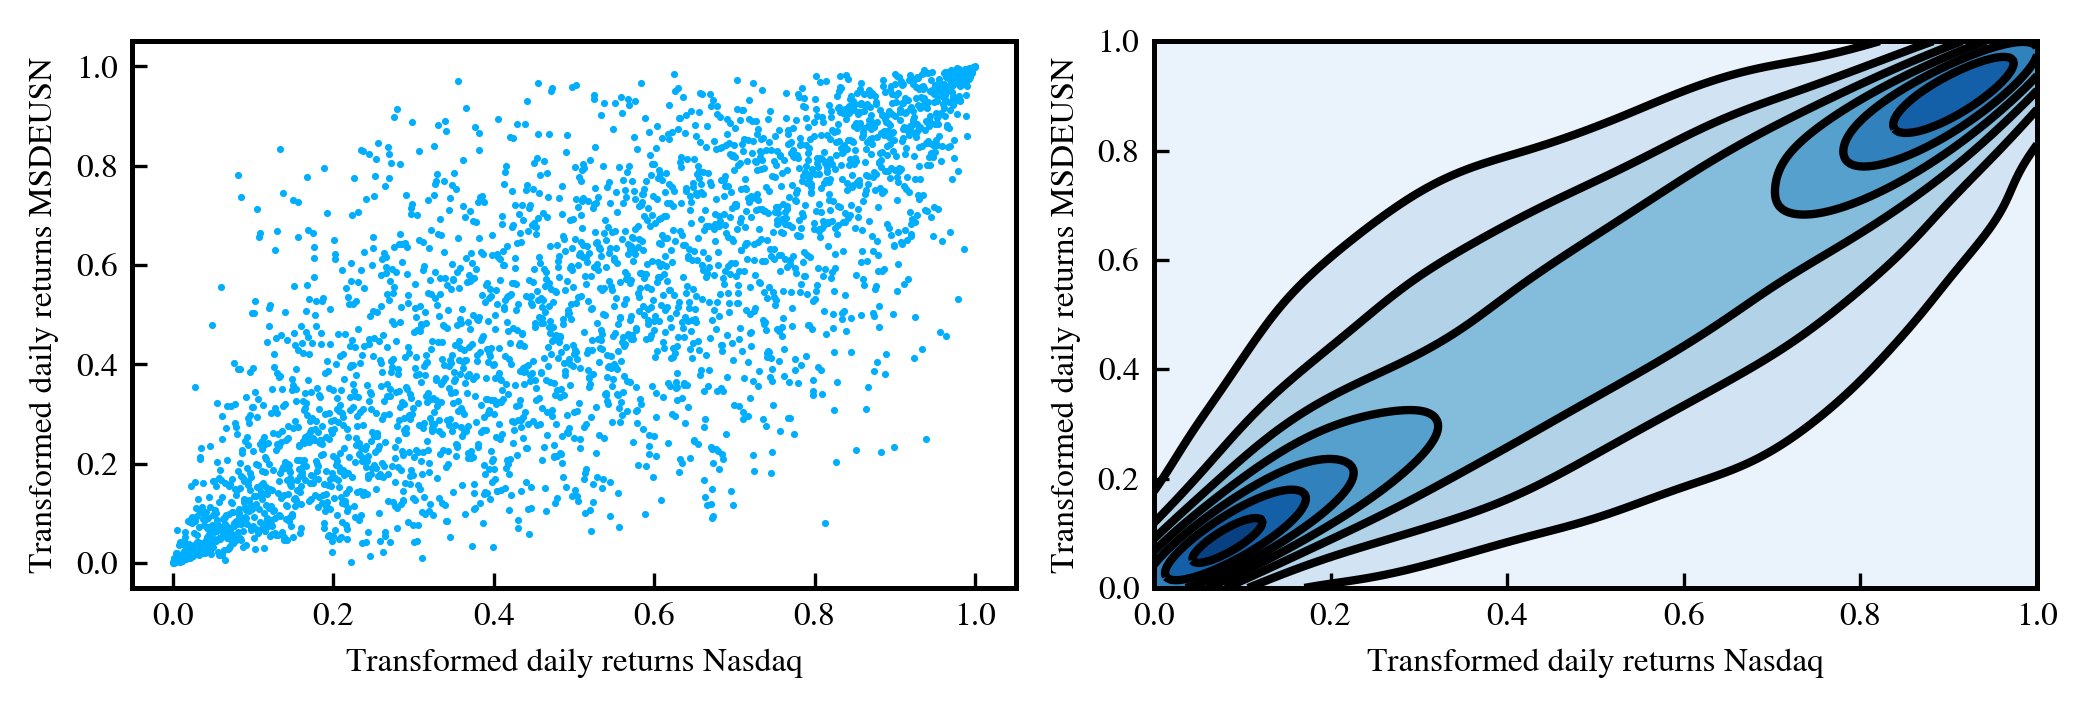

In [1211]:
fig, ax = plt.subplots(ncols=2,figsize=(7,2.4))

ax[0].scatter(nasdaq_uniform,stockseu_uniform,s=0.5)
ax[0].set_xlabel('Transformed daily returns Nasdaq')
ax[0].set_ylabel('Transformed daily returns MSDEUSN')

import scipy.stats as st

data = np.vstack((nasdaq_uniform,stockseu_uniform)).T
x = data[:, 0]
y = data[:, 1]
xmin, xmax = 0,1
ymin, ymax = 0,1

# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:200j, ymin:ymax:200j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

ax[1].set_xlim(xmin, xmax)
ax[1].set_ylim(ymin, ymax)
# Contourf plot
cfset = ax[1].contourf(xx, yy, f, cmap='Blues')
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# Contour plot
#
cset = ax[1].contour(xx, yy, f, colors='k')
# Label plot
#ax[1].clabel(cset, inline=1, fontsize=7)
ax[1].set_xlabel('Transformed daily returns Nasdaq')
ax[1].set_ylabel('Transformed daily returns MSDEUSN')


plt.tight_layout()
plt.savefig('copula_Nasdaq_MSDEUSN.pdf')
pl.show()

In [567]:
from copulae.mixtures import GaussianMixtureCopula

In [570]:
copu = GaussianMixtureCopula(ndim=2,n_clusters=3)
copu.fit(df_daily[stocks[:2]].values)

In [571]:
s = copu.random(100000)

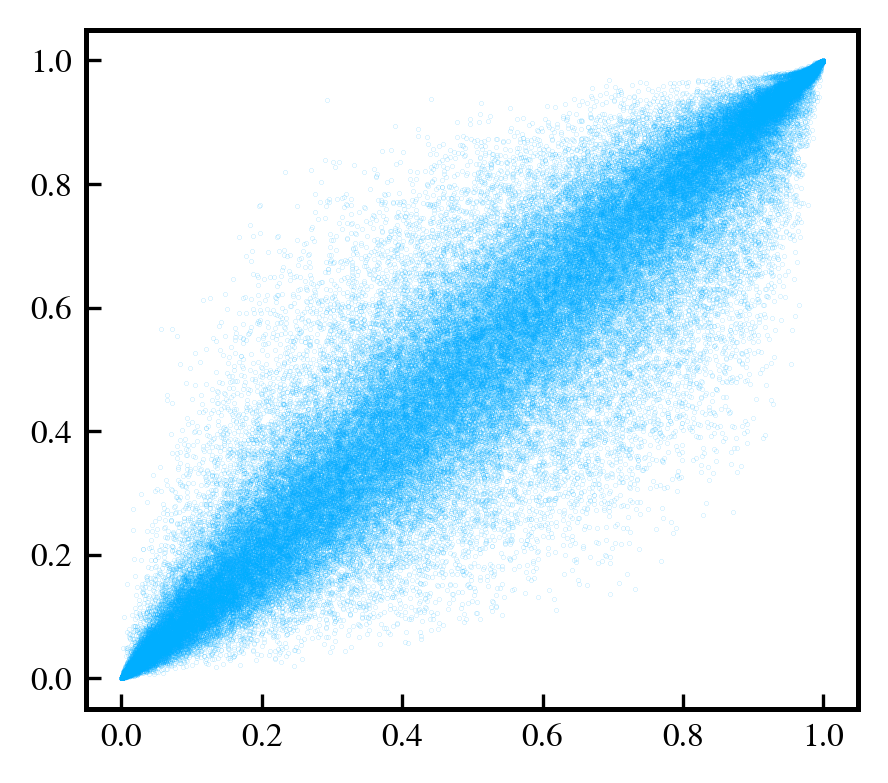

In [572]:
plt.scatter(s[:,0],s[:,1],s=0.001)

In [577]:
# Convert to uniform
simulated_GMM = {}
simulated_emp = {}
for i,stock in enumerate(stocks[:2]):
    icdf_GMM = icdf_GMMs[stock] 
    icdf_emp = icdf_emps[stock]
    # Convert using icdf of GMM to GMM distribution
    simulated_GMM[stock] = icdf_GMM(s[:,i])
    simulated_emp[stock] = icdf_emp(s[:,i])

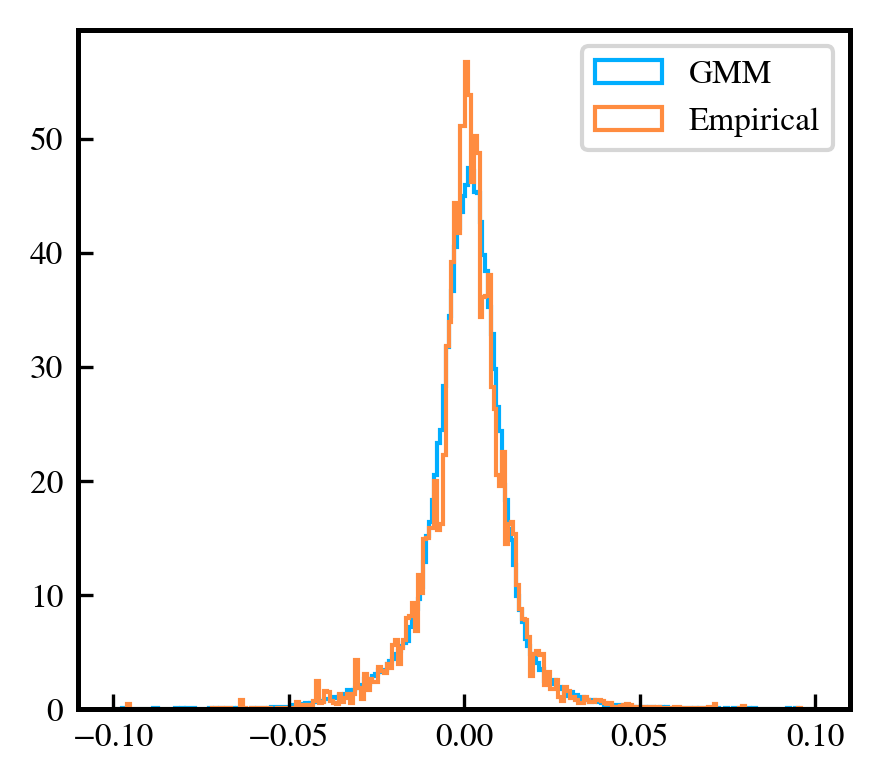

In [578]:
bins=np.linspace(-0.1,0.1,250)
plt.hist(simulated_GMM['Nasdaq'],histtype='step',lw=1,label='GMM',bins=bins,density=True)
plt.hist(simulated_emp['Nasdaq'],histtype='step',lw=1,label='Empirical',bins=bins,density=True)
plt.legend(frameon=1)

In [581]:
simulated_GMM['Nasdaq'].min()

-0.1405413643575847

In [582]:
df_daily.Nasdaq.min()

-0.13149032440974295

Text(0, 0.5, 'True percentile')

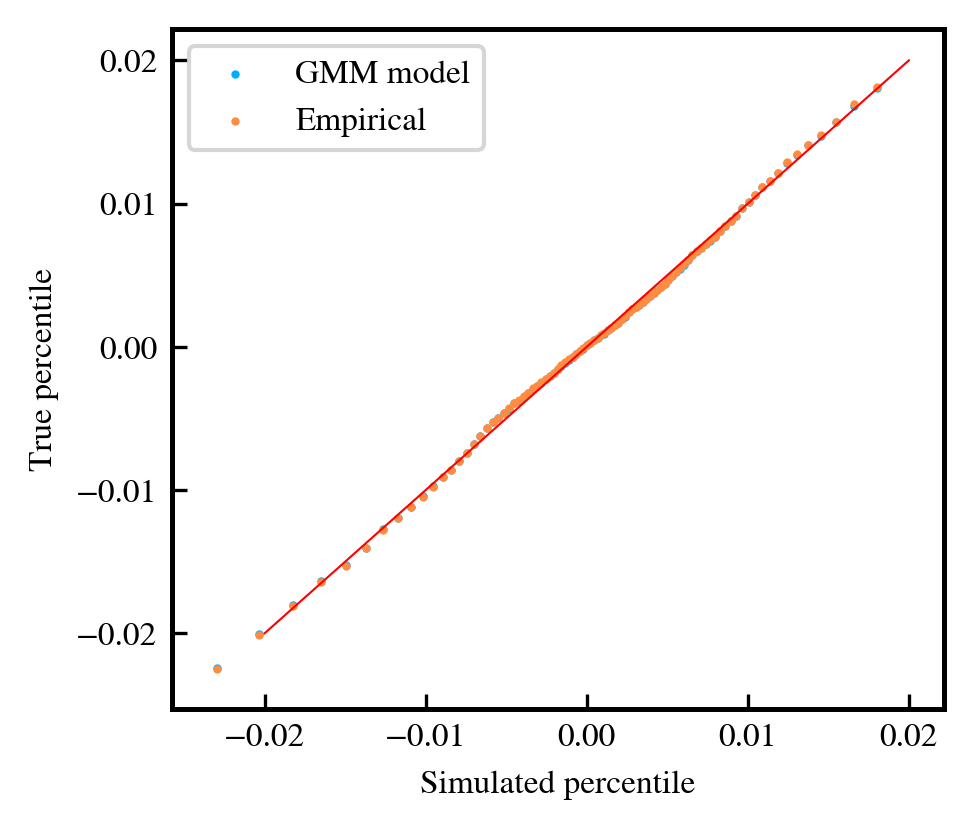

In [1056]:
# Three asset case!
# 1. Define assets
stocks = df_daily.columns[:4]
data = df_daily[stocks]
# 2. Get GMM models and inverses
# Fit GMM to each stock
fitted_GMM = {}
icdf_GMMs = {}
icdf_emps = {}
for stock in stocks:
    gms = []
    bics = []
    scalefac = 1 / df_daily.SBWMEU1L.std()
    data = df_daily[stock].values.reshape(-1,1) * scalefac
    for Ncomp in [2,3,4,5]:
        gm = GaussianMixture(n_components=Ncomp,n_init=50,tol=1e-6)    
        gm.fit(data) 
        gms.append(gm)
        bics.append(gm.bic(data))
    gm = gms[np.argmin(bics)]
    gm.covariances_ /= scalefac**2
    gm.means_ /= scalefac
    fitted_GMM[stock] = gm
    weights = gm.weights_
    means = gm.means_
    variances = gm.covariances_
    # Get inverse CDF
    icdf_GMM,_,_ = inverse_GMM_CDF(weights, means, variances)    
    icdf_emp,_,_ = inverse_GMM_arbitraryCDF(ECDF(df_daily[stock].values.flatten()))    
    icdf_GMMs[stock] = icdf_GMM
    icdf_emps[stock] = icdf_emp    
    print('Done with ',stock)

KeyboardInterrupt: 

In [521]:
# 3. Transform returns into uniform random variables 
df_daily_uniform = pseudo_obs(df_daily[stocks])

In [641]:
# 4. Fit empirical copula
cop = EmpiricalCopula(df_daily_uniform, smoothing='beta')
cop.fit(df_daily_uniform,to_pobs=False)
# Sample from data
s = cop.random(1000000,seed=11)

In [642]:
s.Nasdaq.min()

0.0003443526170798898

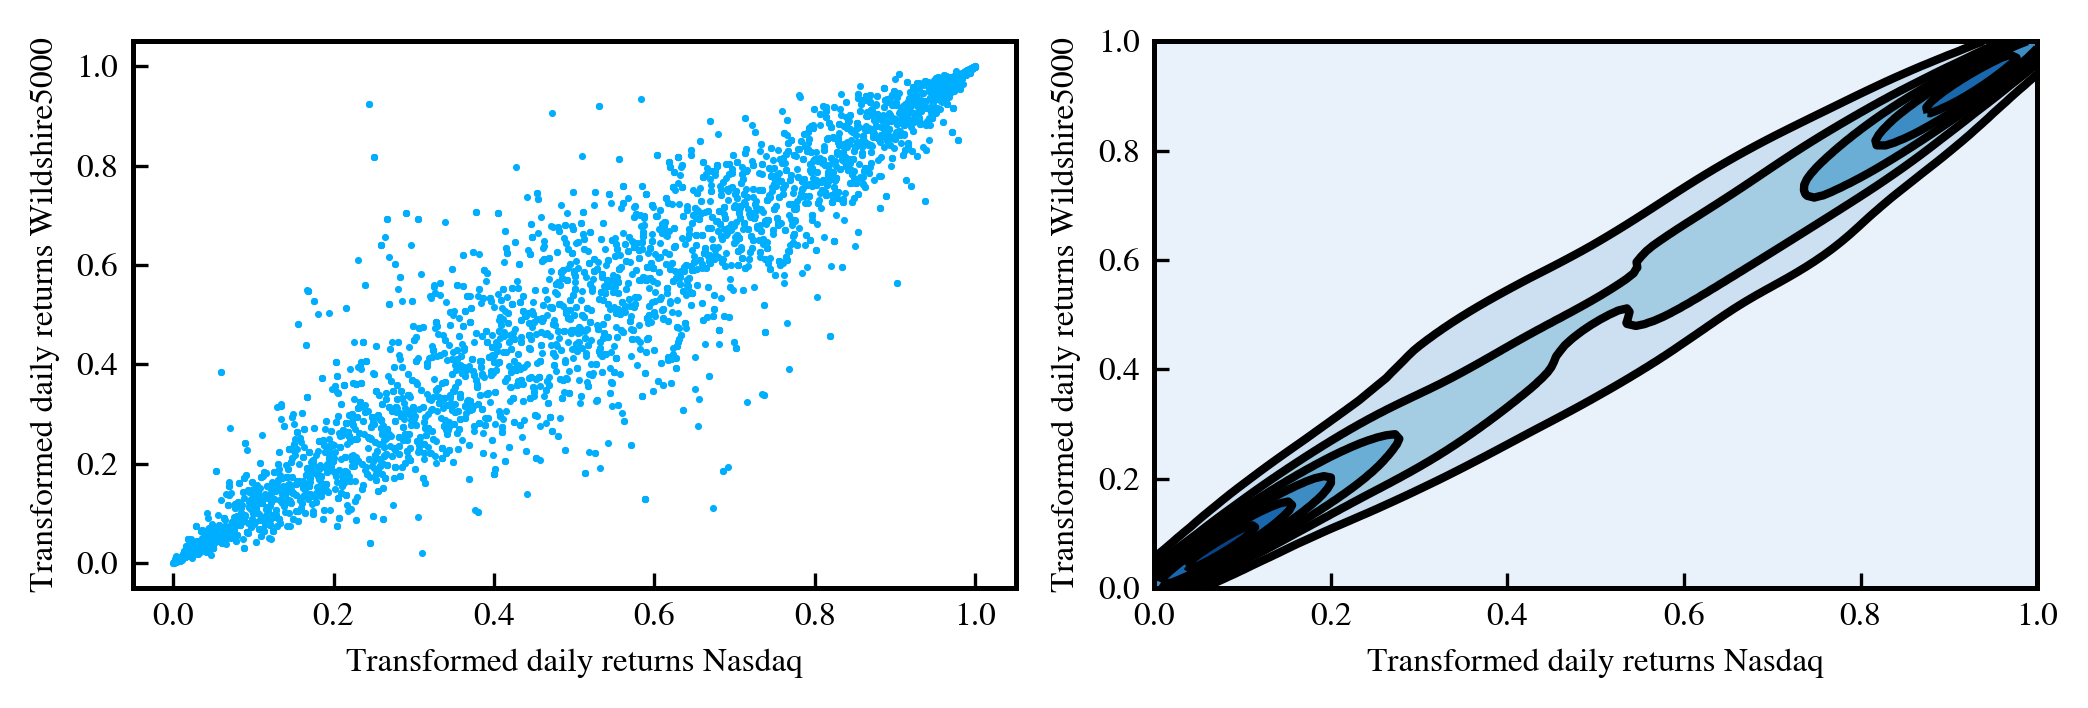

In [529]:
# 5. Draw some examples
fig, ax = plt.subplots(ncols=2,figsize=(7,2.4))


ax[0].set_xlabel('Transformed daily returns Nasdaq')
ax[0].set_ylabel('Transformed daily returns Wildshire5000')

data = np.vstack((s['Nasdaq'],s['Wildshire5000'])).T

ax[0].scatter(data[:5000,0],data[:5000,1],s=0.5)


x = data[:10000, 0]
y = data[:10000, 1]
xmin, xmax = 0,1
ymin, ymax = 0,1

# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

ax[1].set_xlim(xmin, xmax)
ax[1].set_ylim(ymin, ymax)
# Contourf plot
cfset = ax[1].contourf(xx, yy, f, cmap='Blues')
cset  = ax[1].contour(xx, yy, f, colors='k')
ax[1].set_xlabel('Transformed daily returns Nasdaq')
ax[1].set_ylabel('Transformed daily returns Wildshire5000')

plt.tight_layout()
pl.show()

In [587]:
# 6. Convert simulated copula numbers to empirical returns
simulated_GMM = {}
simulated_emp = {}
for i,stock in enumerate(stocks):
    uniform_samples = s[stock]
    icdf_GMM = icdf_GMMs[stock]
    icdf_emp = icdf_emps[stock]
    simulated_GMM[stock] = icdf_GMM(uniform_samples)
    simulated_emp[stock] = icdf_emp(uniform_samples)
s = pd.DataFrame.from_dict(simulated_GMM)

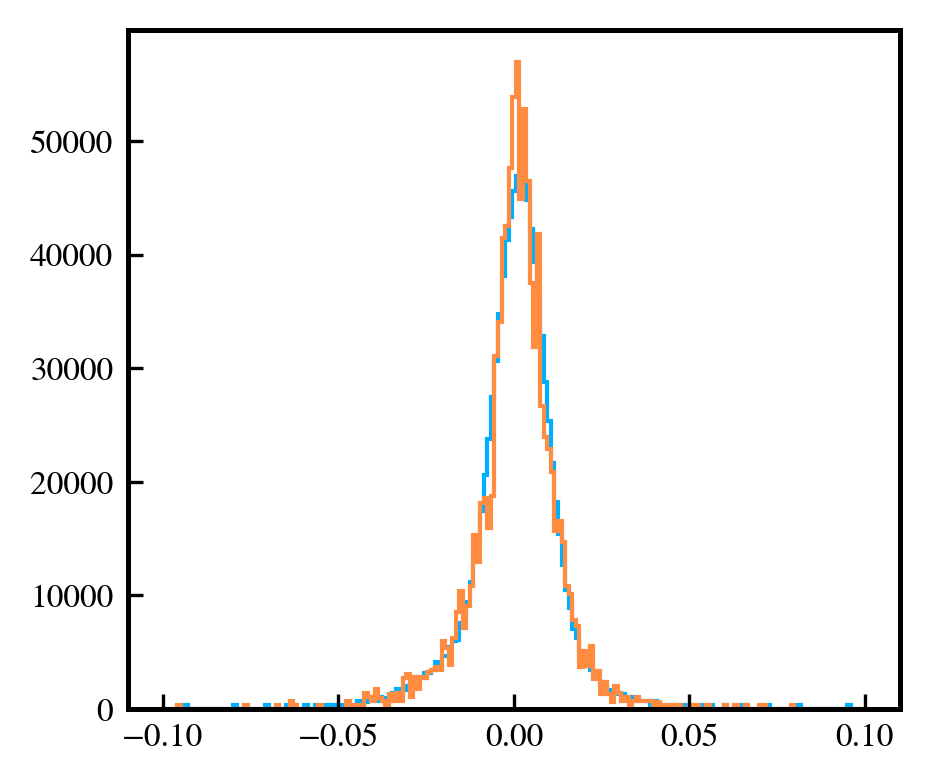

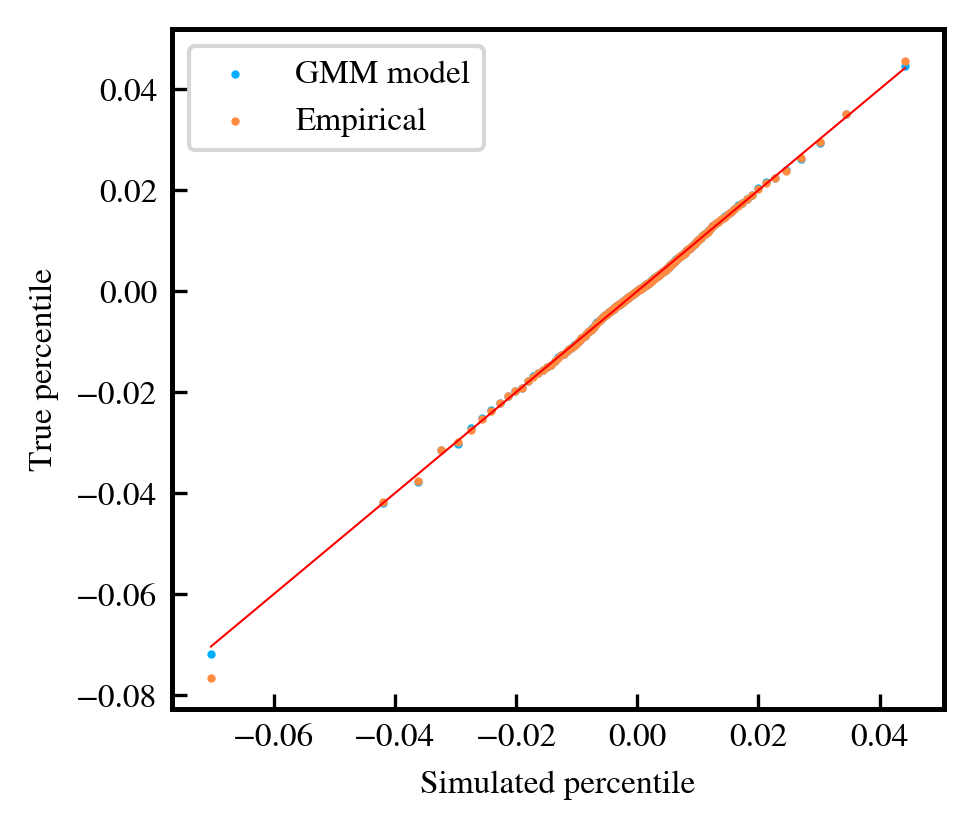

In [532]:
# 7. Some checkplots 
bins = np.linspace(-0.1,0.1,200)
plt.hist(simulated_GMM['Nasdaq'], histtype='step', lw=1,bins=bins)
plt.hist(simulated_emp['Nasdaq'], histtype='step', lw=1,bins=bins)
plt.show()
percentiles = np.arange(0.1,99.9,0.5)
a = np.array([np.percentile(simulated_GMM['Nasdaq'],q=w) for w in percentiles])
b = np.array([np.percentile(df_daily['Nasdaq'],q=w) for w in percentiles])
c = np.array([np.percentile(simulated_emp['Nasdaq'],q=w) for w in percentiles])

plt.scatter(a,b,s=1,label='GMM model')
plt.scatter(a,c,s=1,label='Empirical')
plt.plot([a.min(),a.max()],[a.min(),a.max()],color='red',lw=0.5)
plt.legend(frameon=1)
plt.xlabel('Simulated percentile')
plt.ylabel('True percentile')
plt.show()

Index(['Wildshire5000', 'Nasdaq', 'HML', 'SBWMEU1L', 'CRYTR', 'G250GLEU',
       'MSDEE15N', 'CMBL', 'LESDTREU', 'LETSTREU', 'BEITGA', 'JPGCHECP',
       'LF96TREH', 'LECFTREU', 'LECPTREU', 'LTFRTREU', 'SBWMUD1U', 'LEU1TREU',
       'LG50TREH', 'MSDEEEMN', 'JBCDHECP', 'JGENVHEG', 'JGENVUEG', 'HFRXGLE',
       'SPBDRLEH', 'PD', 'PE', 'Immobilier', 'Structured', 'H0CE', 'BCIF1T',
       'MSDEUSN', 'BRDHTREU'],
      dtype='object')

In [1218]:
# Three asset case!
# 1. Define assets
stocks = ['Wildshire5000', 'Nasdaq', 'HML', 'SBWMEU1L', 'CRYTR', 'G250GLEU',
           'MSDEE15N', 'CMBL', 'LESDTREU', 'LETSTREU', 'BEITGA', 'JPGCHECP',
           'LF96TREH', 'LECFTREU', 'LECPTREU', 'LTFRTREU', 'SBWMUD1U', 'LEU1TREU',
           'LG50TREH', 'MSDEEEMN', 'JBCDHECP', 'JGENVHEG', 'JGENVUEG', 'HFRXGLE',
           'SPBDRLEH', 'PD', 'PE', 'Structured', 'H0CE', 'BCIF1T',
           'MSDEUSN', 'BRDHTREU']
data = df_daily[stocks]
# 2. Get GMM models and inverses
# Fit GMM to each stock
fitted_GMM = {}
icdf_GMMs = {}
icdf_emps = {}
for stock in stocks:
    gms = []
    bics = []
    scalefac = 1 / df_daily[stock].var()
    data = df_daily[stock].values.reshape(-1,1) * scalefac
    for Ncomp in [2,3,4,5]:
        gm = GaussianMixture(n_components=Ncomp,n_init=50,tol=1e-6)    
        gm.fit(data) 
        gms.append(gm)
        bics.append(gm.bic(data))
    gm = gms[np.argmin(bics)]
    weights = gm.weights_
    means = gm.means_
    variances = gm.covariances_
    # Get inverse CDF
    icdf_GMM,_,_ = inverse_GMM_CDF(weights, means, variances,scalefac)
    icdf_emp,_,_ = inverse_GMM_arbitraryCDF(ECDF(df_daily[stock].values.flatten()))    
    icdf_GMMs[stock] = icdf_GMM
    icdf_emps[stock] = icdf_emp    
    gm.covariances_ /= scalefac**2
    gm.means_ /= scalefac
    fitted_GMM[stock] = gm
    print('Done with ',stock)

Done with  Wildshire5000
Done with  Nasdaq
Done with  HML
Done with  SBWMEU1L
Done with  CRYTR
Done with  G250GLEU
Done with  MSDEE15N
Done with  CMBL
Done with  LESDTREU
Done with  LETSTREU
Done with  BEITGA
Done with  JPGCHECP
Done with  LF96TREH
Done with  LECFTREU
Done with  LECPTREU
Done with  LTFRTREU
Done with  SBWMUD1U
Done with  LEU1TREU
Done with  LG50TREH
Done with  MSDEEEMN
Done with  JBCDHECP
Done with  JGENVHEG
Done with  JGENVUEG
Done with  HFRXGLE
Done with  SPBDRLEH
Done with  PD
Done with  PE
Done with  Immobilier
Done with  Structured
Done with  H0CE
Done with  BCIF1T
Done with  MSDEUSN
Done with  BRDHTREU


Text(0.5, 0, 'Uniform sample (inverse quantile)')

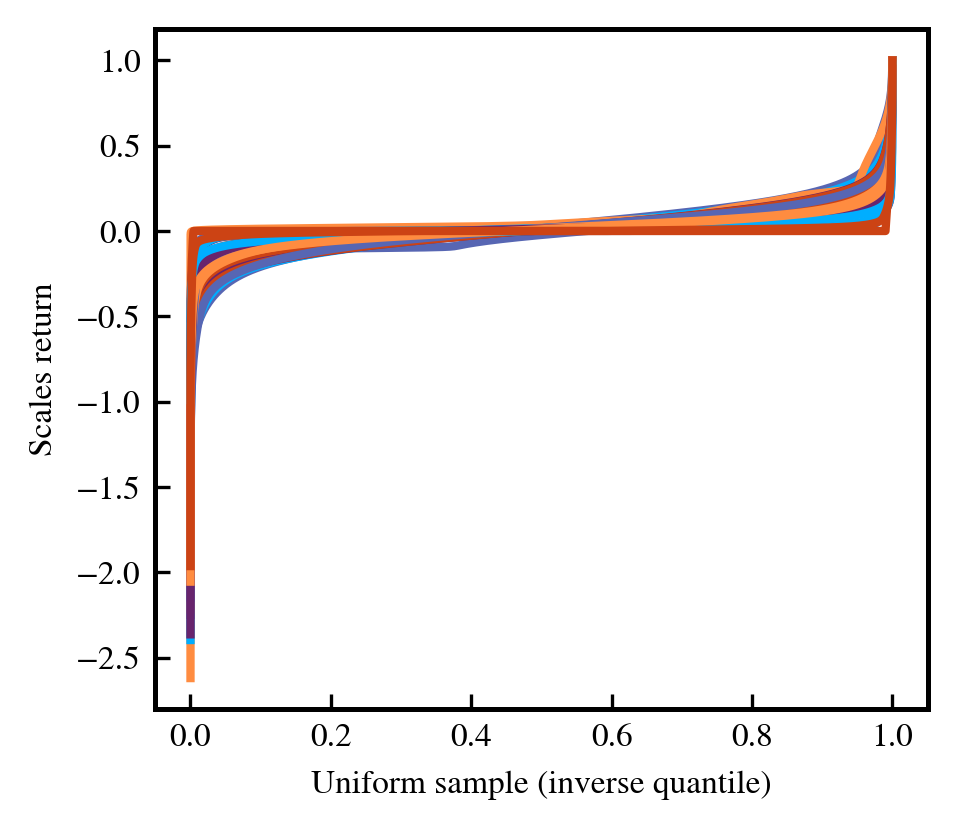

In [1219]:
x=np.arange(0,1,0.0001)
for stock in stocks:
    y=icdf_GMMs[stock](x)
    scale = 1/np.max(y)
    y = y*scale
    plt.plot(x,y)
plt.ylabel('Scales return')
plt.xlabel('Uniform sample (inverse quantile)')

In [1231]:
# 3. Fit copula to sets of assets
copulas = {}
for i in range(len(stocks)-1):
    data = df_daily[stocks[i:i+2]].values
    scalefac = np.mean(1 / np.var(data,axis=0))
    cop = GaussianMixtureCopula(ndim=2,n_clusters=3)
    cop.fit(scalefac*data)
    copulas['+'.join(stocks[i:i+2])] = cop

LinAlgError: singular matrix

In [1240]:
# 4. Sample from first copula
copula_samples = {}
for i in range(len(stocks)-1):
    copula_name = '+'.join(stocks[i:i+2])    
    copula_samples[copula_name] = copulas[copula_name].random(80000)

KeyError: 'LEU1TREU+LG50TREH'

In [1241]:
# 5. Find closest neighbours 
# Save first two sets of samples in df
uniform_GMMcop_samples = pd.DataFrame(copula_samples[list(copula_samples.keys())[0]],columns=stocks[:2])
# Iterate over next samples to find closest
def match(r1,r2):
    deltas, argmins = np.zeros(len(r1)),np.zeros(len(r2))
    for i,return_ in enumerate(r1):
        d_ret = np.abs(return_-r2)
        deltas[i] = np.min(d_ret)
        argmins[i] = np.argmin(d_ret)
    argmins = np.array(argmins,dtype=int)
    return argmins
s_all = uniform_GMMcop_samples.values
for stock in stocks[2:]:
    copula_name = uniform_GMMcop_samples.columns[-1] + '+' + stock
    # Get samples
    s = copula_samples[copula_name]
    # Convert to empirical returns to match
    r1 = icdf_GMMs[uniform_GMMcop_samples.columns[-1]](uniform_GMMcop_samples.iloc[:,-1])
    r2 = icdf_GMMs[uniform_GMMcop_samples.columns[-1]](s[:,0])
    # Match
    argmins = match(r1,r2)
    # Reshuffle new samples and add them to the dataframe
    new_samples = s[argmins]
    uniform_GMMcop_samples[stock] = new_samples[:,1]

KeyError: 'LEU1TREU+LG50TREH'

In [1242]:
# 7. Convert to empirical pdfs
simulated_GMM = {}
for i,stock in enumerate(uniform_GMMcop_samples.columns):
    uniform_samples = uniform_GMMcop_samples[stock]
    icdf_GMM = icdf_GMMs[stock]
    simulated_GMM[stock] = icdf_GMM(uniform_samples)
s = pd.DataFrame.from_dict(simulated_GMM)

In [1243]:
st.ks_2samp(df_daily.CRYTR.values.flatten(), s['CRYTR'].values.flatten())

Ks_2sampResult(statistic=0.011734412676541517, pvalue=0.8331513903229474)

In [1244]:
stocks

['Wildshire5000',
 'Nasdaq',
 'HML',
 'SBWMEU1L',
 'CRYTR',
 'G250GLEU',
 'MSDEE15N',
 'CMBL',
 'LESDTREU',
 'LETSTREU',
 'BEITGA',
 'JPGCHECP',
 'LF96TREH',
 'LECFTREU',
 'LECPTREU',
 'LTFRTREU',
 'SBWMUD1U',
 'LEU1TREU',
 'LG50TREH',
 'MSDEEEMN',
 'JBCDHECP',
 'JGENVHEG',
 'JGENVUEG',
 'HFRXGLE',
 'SPBDRLEH',
 'PD',
 'PE',
 'Structured',
 'H0CE',
 'BCIF1T',
 'MSDEUSN',
 'BRDHTREU']

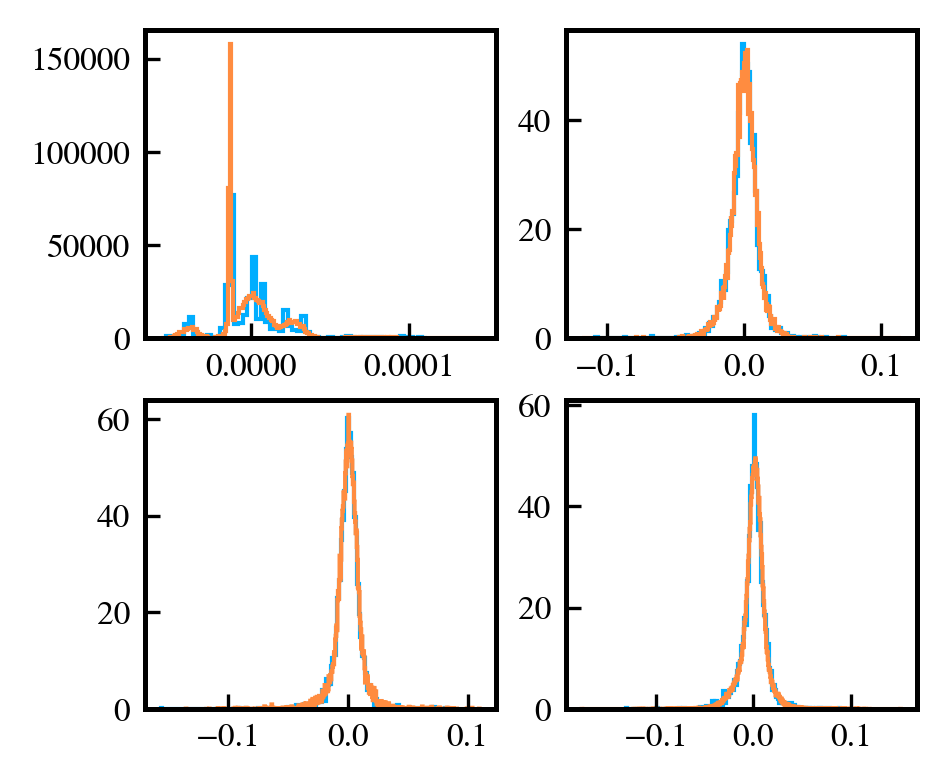

In [1245]:
fig, axes = plt.subplots(2,2)
axes = axes.flatten()
axes[0].hist(df_daily.SBWMEU1L,histtype='step',normed=True)
axes[0].hist(s.SBWMEU1L,histtype='step',normed=True)

axes[1].hist(df_daily.CRYTR,histtype='step',normed=True)
axes[1].hist(s.CRYTR,histtype='step',normed=True)

axes[2].hist(df_daily.G250GLEU,histtype='step',normed=True)
axes[2].hist(s.G250GLEU,histtype='step',normed=True)

axes[3].hist(df_daily.Nasdaq,histtype='step',normed=True)
axes[3].hist(s.Nasdaq,histtype='step',normed=True)

plt.show()

In [1246]:
(s.Nasdaq[s.Nasdaq<np.percentile(s.Nasdaq,1)]).mean()

-0.05043523690357002

In [1247]:
(df_daily.Nasdaq[df_daily.Nasdaq<np.percentile(df_daily.Nasdaq,1)]).mean()

-0.0503875893941295

In [1248]:
s

,Wildshire5000,Nasdaq,HML,SBWMEU1L,CRYTR,G250GLEU,MSDEE15N,CMBL,LESDTREU,LETSTREU,BEITGA,JPGCHECP,LF96TREH,LECFTREU,LECPTREU,LTFRTREU,SBWMUD1U,LEU1TREU
0,-0.010660,-0.009322,-0.005041,-4.611058e-06,-0.011768,0.002446,0.006148,-0.001378,-0.001120,-0.000803,-0.001621,-0.005124,0.001489,0.000267,0.000463,0.000117,0.000007,0.000752
1,0.004907,0.004404,0.002854,-1.321566e-05,-0.000649,-0.003474,-0.007201,-0.000329,0.001938,-0.000212,0.002159,0.000269,0.001170,0.000235,0.000005,0.000462,0.000003,-0.000412
2,0.004221,0.005822,-0.003313,2.859930e-06,0.007571,-0.002011,-0.005296,0.002098,-0.000265,-0.000880,0.000407,-0.000724,0.000951,0.001272,0.001411,-0.002654,0.000007,0.000902
3,0.003936,0.003886,-0.001005,-1.233574e-05,-0.014597,-0.000577,0.003448,-0.000125,-0.000538,-0.000415,-0.004343,0.000484,0.001505,0.000797,0.000934,0.003970,0.000002,0.000191
4,0.000967,0.002889,-0.000505,1.893220e-05,0.007951,0.011987,0.021572,0.003576,0.000596,0.001090,0.000940,0.002108,-0.000033,-0.000538,-0.000642,-0.002748,0.000007,-0.000249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,-0.001045,-0.003051,-0.005057,-1.329110e-05,0.008617,0.004476,-0.003523,0.002156,-0.000284,-0.003408,-0.002379,-0.000558,-0.005319,-0.003601,-0.002983,-0.004517,0.000010,0.000728
79996,0.003436,-0.000968,-0.005536,-8.016678e-07,0.000767,0.002544,0.000191,0.001519,0.001489,0.002287,0.001072,0.003789,0.001429,0.001038,0.000836,0.001679,0.000173,0.000250
79997,-0.014993,-0.018047,0.002546,-1.346708e-05,-0.018025,-0.054710,-0.046488,-0.009714,0.001440,-0.003693,0.002101,-0.001242,0.000602,0.004103,0.003610,0.008227,0.000145,0.003600
79998,0.006597,0.011879,-0.006234,-3.616287e-05,0.013517,0.002338,-0.007624,-0.002949,-0.003655,0.004676,0.004774,0.001720,-0.001281,-0.000404,-0.000498,-0.001553,0.000005,0.000836
